In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


From EDA, it was observed that fraudulent transactions occur only in 'CASH_OUT' and 'TRANSFER', so we consider only the corresponding data for the analysis.

In [3]:
df = pd.read_csv('../data/onlinefraud.csv')
X = df[(df['type']=='CASH_OUT') | (df['type']=='TRANSFER')]
Y = X['isFraud']
X.drop(columns=['isFraud'], axis=1, inplace=True)

# Eliminat the columns that are not relevant for the analysis
X.drop(columns=['nameOrig', 'isFlaggedFraud', 'nameDest'], axis=1, inplace=True)

In [4]:
#Encode transaction type as binary
X.loc[X['type']=='TRANSFER', 'type'] = 0
X.loc[X['type']=='CASH_OUT', 'type'] = 1
X['type'] = X['type'].astype(int)


#### There are many zero balances in the destination account. Are those missing values?

Data has many zero balance in the destination acount both before and after a non-zero amount has been transferred. Such transactions are around 50% in fradulent and 0.06% in non-fraudulent transactions.

In [5]:
df_fraud = X.loc[Y==1]
df_nonfraud = X.loc[Y==0]

print(f"The fraction of fraudulent transactions with oldbalanceDest=0 and newbalanceDest=0 even when the amount transferred is non-zero: {len(df_fraud[(df_fraud['oldbalanceDest'] == 0) & (df_fraud['newbalanceDest']==0) & (df_fraud['amount']!=0)])/len(df_fraud)}")
print(f"The fraction of non-fraudulent transactions with oldbalanceDest=0 and newbalanceDest=0 even when the amount transferred is non-zero: {len(df_nonfraud[(df_nonfraud['oldbalanceDest'] == 0) & (df_nonfraud['newbalanceDest']==0) & (df_nonfraud['amount']!=0)])/len(df_nonfraud)}")


The fraction of fraudulent transactions with oldbalanceDest=0 and newbalanceDest=0 even when the amount transferred is non-zero: 0.4955558261293072
The fraction of non-fraudulent transactions with oldbalanceDest=0 and newbalanceDest=0 even when the amount transferred is non-zero: 0.0006176245277308345


Since the fraction of transactions where the destination balance is zero both before and after a non-zero amount has been transferred is high in fraudulent transactions (i.e., around 50%) when compared to non-fraudulent transactions (around 0.06%), the zeros cannot be treated as missing values. If these values are imputed, this would mask the fradulent transactions and show them as non-fradulent. Instead replacing these values with -1 will be useful in detecting the fradulent transactions.

In [6]:
X.loc[(X['oldbalanceDest']==0) & (X['newbalanceDest']==0) & (X['amount']!=0), ['oldbalanceDest', 'newbalanceDest']] = -1

In [7]:
print(f"The fraction of fraudulent transactions with oldbalanceOrig=0 and newbalanceOrig=0 even when the amount transferred is non-zero: {len(df_fraud[(df_fraud['oldbalanceOrg'] == 0) & (df_fraud['newbalanceOrig']==0) & (df_fraud['amount']!=0)])/len(df_fraud)}")
print(f"The fraction of non-fraudulent transactions with oldbalanceOrig=0 and newbalanceOrig=0 even when the amount transferred is non-zero: {len(df_nonfraud[(df_nonfraud['oldbalanceOrg'] == 0) & (df_nonfraud['newbalanceOrig']==0) & (df_nonfraud['amount']!=0)])/len(df_nonfraud)}")


The fraction of fraudulent transactions with oldbalanceOrig=0 and newbalanceOrig=0 even when the amount transferred is non-zero: 0.0030439547059539756
The fraction of non-fraudulent transactions with oldbalanceOrig=0 and newbalanceOrig=0 even when the amount transferred is non-zero: 0.4737321319703598


There are also transactions where the oldbalanceOrig and newbalanceOrig is zero before and after a non-zero amount is transacted. But this fraction is very less in fraudulent transactions (0.3%) compared to non-fraudulent transactions. For the same reasoning as above, will not impute these data and keep it as 0 here.

#### Feature engineering

From above, we can see that although the amount tansacted is non-zero, the newBalanceDest is zero pointing towards fraudulent transactions. So, here two new features are created for error balances in the originating and destination accounts which could be important features.

In [8]:
X['errorBalanceOrig'] = X['newbalanceOrig'] + X['amount'] - X['oldbalanceOrg']
X['errorBalanceDest'] = X['oldbalanceDest'] + X['amount'] - X['newbalanceDest']


#### Is there correlation between these two new features and other features?

In [9]:
X_fraud = X.loc[Y==1]
X_nonfraud = X.loc[Y==0]

Text(0.5, 1.0, 'Non-Fraudulent transactions')

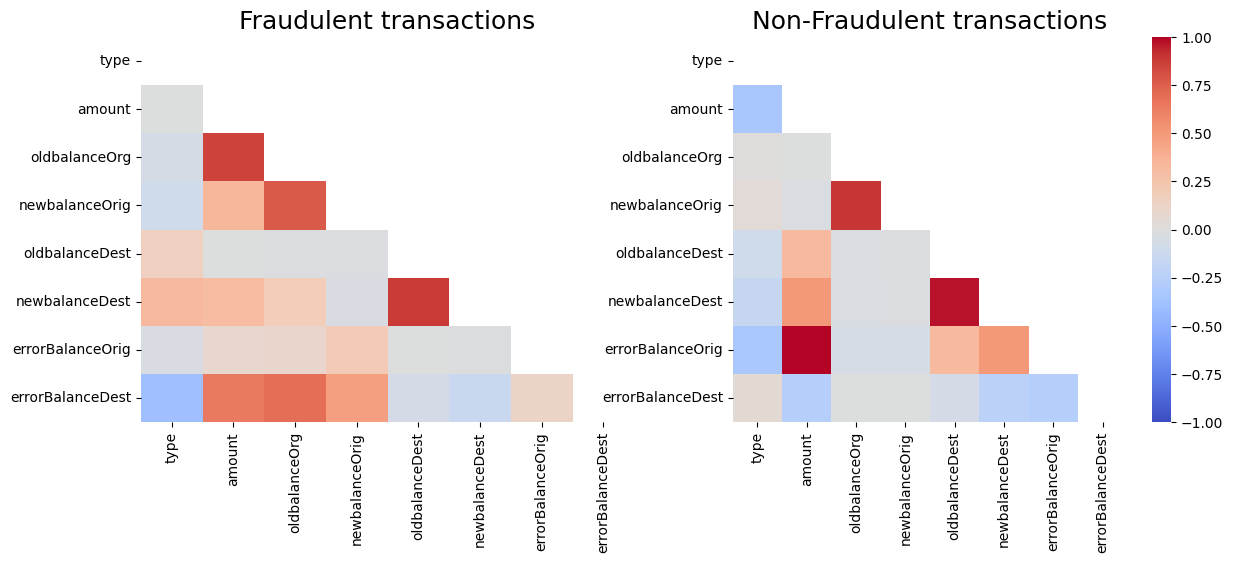

In [10]:
#Plot heatmap

corrFraud = X_fraud.iloc[:, 1:].corr()
mask = np.triu(np.ones_like(corrFraud, dtype=bool))

fig, axes = plt.subplots(1, 2, figsize = (14, 5))

sns.heatmap(corrFraud, ax=axes[0], annot=True, cmap='coolwarm', fmt=".2f", mask=mask, annot_kws={"size":4}, vmin=-1, vmax=1, cbar=False)
axes[0].set_title('Fraudulent transactions', size = 18)

corrNonFraud = X_nonfraud.iloc[:, 1:].corr()
mask = np.triu(np.ones_like(corrNonFraud, dtype=bool))
sns.heatmap(corrNonFraud, ax=axes[1], annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size":4}, mask=mask, vmin=-1, vmax=1)
axes[1].set_title('Non-Fraudulent transactions', size = 18)


Amongst the fraudulent transactions, there is a high correlation observed between amount and errorBalanceDest and oldbalanceOrg whereas in non-fraudulent transactions high correlation is observed between amount and errorBalanceOrig.

In [11]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.0,0.0,-1.0,-1.00,0.00,181.0
3,1,1,181.00,181.0,0.0,21182.0,0.00,0.00,21363.0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,213808.94,182703.5
19,1,0,215310.30,705.0,0.0,22425.0,0.00,214605.30,237735.3
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,300850.89,-2401220.0


In [12]:
Y

2          1
3          1
15         0
19         0
24         0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 2770409, dtype: int64